# Modulacion en frecuencias Integrada

In [10]:
#Importamos algunas librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from nltk.tokenize import word_tokenize
import we_to_signal as wes

## Modulación

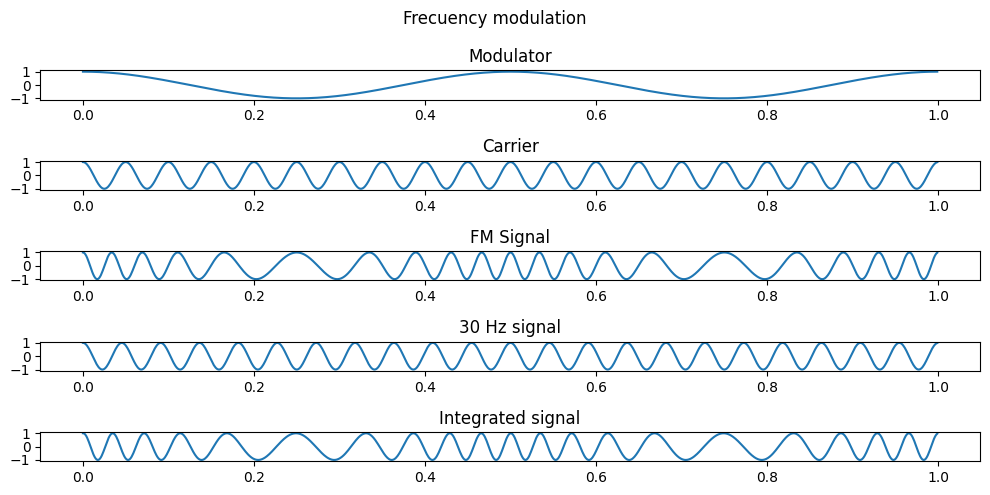

In [11]:
from scipy.integrate import simpson

dt = 0.001
t = np.arange(0,1,dt)

f_carrier = 20
carrier = np.cos(2*np.pi*f_carrier*t)

f_moduladora = 2
moduladora = np.cos(2*np.pi*f_moduladora*t)

k = 10
sig_modulada = np.cos(2*np.pi*f_carrier*t + (k/f_moduladora)*np.sin(2*np.pi*f_moduladora*t))

integral = [simpson(y=moduladora[:i],dx=dt) for i in range(1,len(moduladora))]
integral.insert(0,0)
integral = np.array(integral)

k_int = 58
sig_modulada_integrada = np.cos(2*np.pi*f_carrier*t + k_int*integral)

fig,ax = plt.subplots(5,figsize=(10,5))

fig.suptitle("Frecuency modulation")

ax[0].set_title("Modulator")
ax[0].plot(t,moduladora)

ax[1].set_title("Carrier")
ax[1].plot(t,carrier)

ax[2].set_title("FM Signal")
ax[2].plot(t,sig_modulada)

ax[3].set_title("30 Hz signal")
ax[3].plot(t,np.cos(2*np.pi*22*t))

ax[4].set_title("Integrated signal")
ax[4].plot(t,sig_modulada_integrada)

fig.tight_layout()

In [12]:
def modulate(moduladora,carrier_hz,k,dt,duration_s):
    """Ocupa x para modular una carrier de amplitud 1 y frecuencia carrier_hz"""
    # Samples per second sps

    # Duration duration_s in seconds

    # carrier_hz: Frequency of the carrier
    # fm_hz: Frequency of the frequency modulator
    # k_p: deviation constant

    t = np.arange(0,duration_s,dt)

    carrier_phi = 2*np.pi*t*carrier_hz
    
    integral = [simpson(y=moduladora[:i],dx=dt) for i in range(1,len(moduladora))]
    integral.insert(0,0)
    integral = np.array(integral)
    
    fm_signal = np.cos(carrier_phi + k*integral)

    return fm_signal

## Carga de corpus

In [13]:
#Con los poemas separados, los metemos en un diccionario de dataframes
import os

data_path = "data/"
emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

json_files = sorted([pos_json for pos_json in os.listdir(data_path) if pos_json.endswith('.json')])
json_files.remove('Poems.json')
json_files.remove('missing.json')

em_poems = {}
for e in emotion_list:
    f = open(data_path+e+".json")
    df_ = pd.DataFrame(json.load(f))
    em_poems[e] = df_
em_poems["anger"]

,poem,id
0,i do know this it's nothing i can hold\nlast ...,10
1,the fear o' hell's a hangman's whip\nto haud t...,18
2,but since i laid a hand thereon\nand found a h...,88
3,falsely i pointed to sum in text\nseriously he...,99
4,i'll wear my jealous reflection\njuice of lemo...,125
...,...,...
2461,new snow on a leaf\nlike granulated sugar\nmak...,93124
2462,new earth and old earth\na trio of guardians\n...,93138
2463,destructions despair\nconstructions hope toge...,93217
2464,hot dry summers will\nbake paint right off the...,93226


In [14]:
#Carga de embeddings
from gensim.models import Word2Vec
from gensim.models import FastText

emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

poems_w2v = {}
poems_fst = {}

for e in emotion_list:
    w2v_lines = Word2Vec.load("embeddings_poems/w2v_model_"+e)
    fst_lines = FastText.load("embeddings_poems/fst_model_"+e)
    poems_w2v[e] = w2v_lines
    poems_fst[e] = fst_lines

## Similitud entre emociones


In [15]:
#Calculamos la interseccion entre palabras de fst,w2v y todas las emociones

words_intersection = set()
for emotion in emotion_list:
    fst = set(poems_fst[emotion].wv.key_to_index.keys())
    w2v = set(poems_w2v[emotion].wv.key_to_index.keys())
    intersection = fst & w2v
    if not words_intersection:
        words_intersection = words_intersection.union(intersection)
    else:
        words_intersection = words_intersection.intersection(intersection)

display(len(words_intersection))

677

In [16]:
#Eliminamos las stopwords de la interseccion
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words_intersection = words_intersection - stop_words
len(words_intersection)

562

In [17]:
#Funciones de procesamiento y obtencion de frecuencia de las palabras
from collections import Counter

def get_word_freq(dataframe:pd.DataFrame,col:str,emotion_list:list):
    """
    Calculates for Counter model of each emotion text corpus.

    Parameters
    ------------
    dataframe: pandas Dataframe with documents.
    col:str name of the column where the documents are.
    emotion_list: list with emotions

    Returns
    -----------
    dict:
        dictionary with keys(emotions_list) an each key with his self Counter model.
    """
    freq_dict = {}
    for emotion in emotion_list:
        tokens = dataframe[emotion][col].apply(lambda x: [token for token in word_tokenize(x)])
        l1 = tokens.values.tolist()
        l2 = [w for l in l1 for w in l ]
        freq_dict[emotion] = Counter(l2)
    return freq_dict

def text_clean(sent):
    """
    Clean the text of some chars
    
    Parameters
    -------------
    sent: str
        Sentence to be cleaned
    
    Returns
    -------------
    str:
        Sentence cleaned.
    """
    import re
    from unidecode import unidecode
    import unicodedata as ud

    d = {ord('\N{combining acute accent}'):None}
    sent = ud.normalize('NFD',sent).translate(d)
    sent = re.sub(r"[^\w .,;?!\n]+", "", sent)
    sent = re.sub(r"[^\w .,;?!]", " ", sent)
    sent = re.sub(r"[^\w .,]", ".", sent)
    sent = re.sub(r"[^\w ]", "", sent)
    sent = re.sub(r"[0-9]", "", sent)
    sent = re.sub(r"[α-ωςϑϕϜϝϞϠϰϱ]", "", sent)
    sent = re.sub(r"[ΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩ]", "", sent)
    sent = re.sub(r"[A-Z]{2}", "", sent)
    return sent

In [18]:
#Creamos una copia de los poemas y calculamos la frecuencia de aparición de las palabras
em_poem_c = dict()

for emotion in emotion_list:
    em_poem_c[emotion] = em_poems[emotion].copy()

for emotion in emotion_list:
    em_poem_c[emotion]["poems_clean"] = em_poem_c[emotion]["poem"].apply(text_clean)

freq_dict = get_word_freq(em_poem_c,"poems_clean",emotion_list)

In [19]:
#Creamos el dataframe de las palabras con su correlacion pearson
from itertools import combinations
from scipy.stats import pearsonr

def create_correlation_df(models,emotion_list,words_intersection,freq_dict):
    """
    Crea un dataset con informacion de la correlacion de las palabras
    entre emociones añadiendo su frecuencia de aparicion en el corpus.
    """
    emotion_combinations = list(combinations(emotion_list,2))

    words_embbed_info = {}
    words_embbed_info["words"] = list(words_intersection)

    for emotion in emotion_list:
        words_embbed_info["f_"+emotion] = []

    for comb in emotion_combinations:
        words_embbed_info["P_"+str(comb)] = []

    for word in words_intersection:
        #Añadimos la frecuencia por cada emoción
        for emotion in emotion_list:
            words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

        #Calculamos la correlacion pearson para cada par de emociones.    
        for comb in emotion_combinations:
            emotion_a = comb[0]
            emotion_b = comb[1]

            words_embbed_info["P_"+str(comb)].append(pearsonr(models[emotion_a].wv.get_vector(word,norm=True),models[emotion_b].wv.get_vector(word,norm=True)))

    return pd.DataFrame(words_embbed_info)

In [20]:
words_embbed_w2v_info = create_correlation_df(poems_w2v,emotion_list,words_intersection,freq_dict)
words_embbed_fst_info = create_correlation_df(poems_fst,emotion_list,words_intersection,freq_dict)

display(words_embbed_w2v_info)
display(words_embbed_fst_info)

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,waves,28,60,12,52,91,96,19,47,"(0.8779000721436682, 4.1638748979637815e-33)",...,"(0.8255029065447009, 4.383880370424196e-26)","(0.8807184223656149, 1.4226408406670425e-33)","(0.888546483820259, 6.212119633361198e-35)","(0.8612184238664088, 1.4552405106547302e-30)","(0.8708542659212144, 5.45483755696592e-32)","(0.8717008239696848, 4.0368654475116485e-32)","(0.8462345101499064, 1.5141343243946845e-28)","(0.8984936442207382, 8.144983564416605e-37)","(0.8833126789163653, 5.167121256511962e-34)","(0.8535959109227874, 1.648955623975691e-29)"
1,light,93,414,43,240,575,451,44,465,"(0.875501840588257, 1.0171609163730675e-32)",...,"(0.7899662915736327, 1.5367047308447446e-22)","(0.8648497428925006, 4.349128875190394e-31)","(0.8837470385686708, 4.350963407787774e-34)","(0.8582319215693175, 3.8310217582910895e-30)","(0.851316195111657, 3.3186608160026705e-29)","(0.8612954518114815, 1.4189369421530273e-30)","(0.834527954387874, 4.093591578379718e-27)","(0.8968679425628031, 1.704310726502409e-36)","(0.8790345403201184, 2.7111638537744884e-33)","(0.8655938943808384, 3.380902098495662e-31)"
2,red,44,144,31,109,184,146,17,157,"(0.8767644279665568, 6.370677301121e-33)",...,"(0.7989246799825706, 2.2935117974291964e-23)","(0.8715539891320837, 4.2538968838487684e-32)","(0.885925083258974, 1.8182552368583784e-34)","(0.8585626467287713, 3.445375849800751e-30)","(0.8514545281268543, 3.1818234302529584e-29)","(0.8586282327279406, 3.373533354563474e-30)","(0.8298085944226666, 1.4391943256685617e-26)","(0.8865178575110014, 1.4295201971803422e-34)","(0.8789722303271152, 2.7761244366378728e-33)","(0.8619934949461382, 1.1278045226911593e-30)"
3,ice,18,49,7,43,25,34,15,31,"(0.8839537826065876, 4.008141770470455e-34)",...,"(0.8369044840671848, 2.140946420225244e-27)","(0.8770686136633256, 5.6871629981884524e-33)","(0.8911794763798802, 2.0552750242548915e-35)","(0.8754319945795412, 1.0436774629853601e-32)","(0.8707055761797198, 5.749756461834384e-32)","(0.8840679555064174, 3.8302824983378848e-34)","(0.869627083737591, 8.407624999235972e-32)","(0.8961232687304757, 2.380399189831736e-36)","(0.8995599552802136, 4.98432267176081e-37)","(0.8853818580207901, 2.2640236667295496e-34)"
4,way,83,289,70,174,264,231,28,327,"(0.9074574956458503, 1.0951572278044295e-38)",...,"(0.8694104104636273, 9.070892758828269e-32)","(0.880473475200595, 1.5634940146622102e-33)","(0.8875983055911302, 9.189250611072156e-35)","(0.8832095696771091, 5.381815816254683e-34)","(0.8812363992941428, 1.164382435884683e-33)","(0.8881886283897984, 7.20436094395298e-35)","(0.8928805094377255, 9.906522393054111e-36)","(0.9073893679153209, 1.1334663573914113e-38)","(0.887340690585915, 1.021446459695342e-34)","(0.8924246929284937, 1.2060716844043127e-35)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,river,20,133,19,88,96,108,17,75,"(0.8796360822610707, 2.1557061158360766e-33)",...,"(0.8116303695315794, 1.3019138585716276e-24)","(0.8712374951608111, 4.761158044162964e-32)","(0.886192197703681, 1.6317477281502644e-34)","(0.8491100942917045, 6.458251494518532e-29)","(0.867332802095154, 1.8659213925969774e-31)","(0.8671610180970727, 1.9795043881871758e-31)","(0.8341210434425972, 4.569366401869957e-27)","(0.8950226653027756, 3.882403353264397e-36)","(0.8734749524454369, 2.1331681901253247e-32)","(0.8410119108641539, 6.812018213832595e-28)"
558,natures,6,23,6,14,57,33,10,35,"(0.9076129461320255, 1.0124223112594066e-38)",...,"(0.8499235042038665, 5.05873181445177e-29)","(0.8874817595290833, 9.639962981671111e-35)","(0.8753523203770868, 1.0747499569874459e-32)","(0.865017141029296, 4.110135568986048e-31)","(0.8910

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,waves,28,60,12,52,91,96,19,47,"(0.7744743332348049, 3.3448718044879378e-21)",...,"(0.7550234153935484, 1.1508231305215948e-19)","(0.7298534034818761, 7.064528387914588e-18)","(0.8712790796117923, 4.69128256751667e-32)","(0.7783299241928667, 1.5904641008186904e-21)","(0.8248697986548001, 5.150748545621228e-26)","(0.6917809525819243, 1.5981404652594306e-15)","(0.7938229408467156, 6.854218349355031e-23)","(0.6795141596195854, 7.704207201515853e-15)","(0.8390226568104667, 1.1909057778426157e-27)","(0.7468732293818301, 4.602224502957342e-19)"
1,light,93,414,43,240,575,451,44,465,"(0.7702429099331664, 7.437892086088414e-21)",...,"(0.7683930833616502, 1.0492011755385908e-20)","(0.7868836355735509, 2.894789933681142e-22)","(0.8516052098451432, 3.039035234827717e-29)","(0.7901999497226027, 1.464051966238007e-22)","(0.8317836188388147, 8.544281378227378e-27)","(0.66342365693989, 5.42378394127073e-14)","(0.7941726173984875, 6.364996451187247e-23)","(0.7052761621461265, 2.581454700215899e-16)","(0.8455370877021486, 1.856838650845752e-28)","(0.7242959898086363, 1.64869837829338e-17)"
2,red,44,144,31,109,184,146,17,157,"(0.8781518242014974, 3.787098491691108e-33)",...,"(0.8575864061776525, 4.708858297927308e-30)","(0.8651412723486029, 3.94124235059155e-31)","(0.8742175308688585, 1.6286786992668187e-32)","(0.8465083239515512, 1.397189350565703e-28)","(0.8668159008847521, 2.2284669105674725e-31)","(0.8046645825581596, 6.441210094995661e-24)","(0.8492864024752982, 6.125991674778381e-29)","(0.8397483072366069, 9.722172527173537e-28)","(0.8836303685714857, 4.556898280050963e-34)","(0.8422211646720341, 4.832434977869852e-28)"
3,ice,18,49,7,43,25,34,15,31,"(0.8838436618288754, 4.187319977839386e-34)",...,"(0.8871589831779835, 1.1003955152263407e-34)","(0.8773844118760057, 5.053423115556166e-33)","(0.8749374310410067, 1.251739018596499e-32)","(0.8907162700910956, 2.501885716905832e-35)","(0.8451510067556365, 2.0779686634642366e-28)","(0.8356449106209874, 3.022457260583264e-27)","(0.8704810887702468, 6.224733908439548e-32)","(0.8690419357901447, 1.0317992366980998e-31)","(0.8981040696231124, 9.73247385098524e-37)","(0.8790209266476695, 2.7252286467008038e-33)"
4,way,83,289,70,174,264,231,28,327,"(0.845685137703717, 1.778281767480759e-28)",...,"(0.9010747079212835, 2.4574108790683476e-37)","(0.8682240463411881, 1.3714225010507642e-31)","(0.8742894954099908, 1.5864957736580377e-32)","(0.844259360694387, 2.6914332570986426e-28)","(0.8429112551260654, 3.9674375788828443e-28)","(0.8447399768679742, 2.3416134863041946e-28)","(0.8505103764114204, 4.2376004151946185e-29)","(0.8605912931964568, 1.7865585282932588e-30)","(0.8766755537479517, 6.585095729181571e-33)","(0.8417381459834317, 5.544668695735707e-28)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,river,20,133,19,88,96,108,17,75,"(0.8526471831283645, 2.2092286904969325e-29)",...,"(0.8676744870481492, 1.6586003894094303e-31)","(0.877325176734792, 5.166789861773005e-33)","(0.87486799953653, 1.2840158236896107e-32)","(0.877864932247721, 4.219295549898571e-33)","(0.8655907779716128, 3.384480237764817e-31)","(0.810053391011197, 1.880537399396179e-24)","(0.8635697039032719, 6.683746161615953e-31)","(0.8536451449010938, 1.6240233212946277e-29)","(0.9021046519479087, 1.5093871711750873e-37)","(0.8651511301163025, 3.9281241246727517e-31)"
558,natures,6,23,6,14,57,33,10,35,"(0.874636142404697, 1.3977990111617558e-32)",...,"(0.8783984439785752, 3.450379295491178e-33)","(0.8685018715217585, 1.2453377139343142e-31)","(0.8749625140058241, 1.2402745914102893e-32)","(0.8693212329991903, 9.358480457775845e-32)","(0.84566903

In [35]:
# Boxplots correlacion 
def box_plot_word_info(df,suptitle:str="Box plot"):
    import re
    fig,ax = plt.subplots(8,figsize=(16,30))
    columns = df.columns
    i = 0
    for emotion in emotion_list:
        data = []
        labels = []
        for column in columns:
            if emotion in column:
                if 'f_' in column:
                    continue
                data.append([element[0] for element in df[column]])
                labels.append(re.sub(r"P_","",column))
        ax[i].boxplot(data)
        ax[i].set_xticklabels(labels)
        ax[i].set_title(emotion)
        i+=1
    fig.suptitle(suptitle,y=0.9)

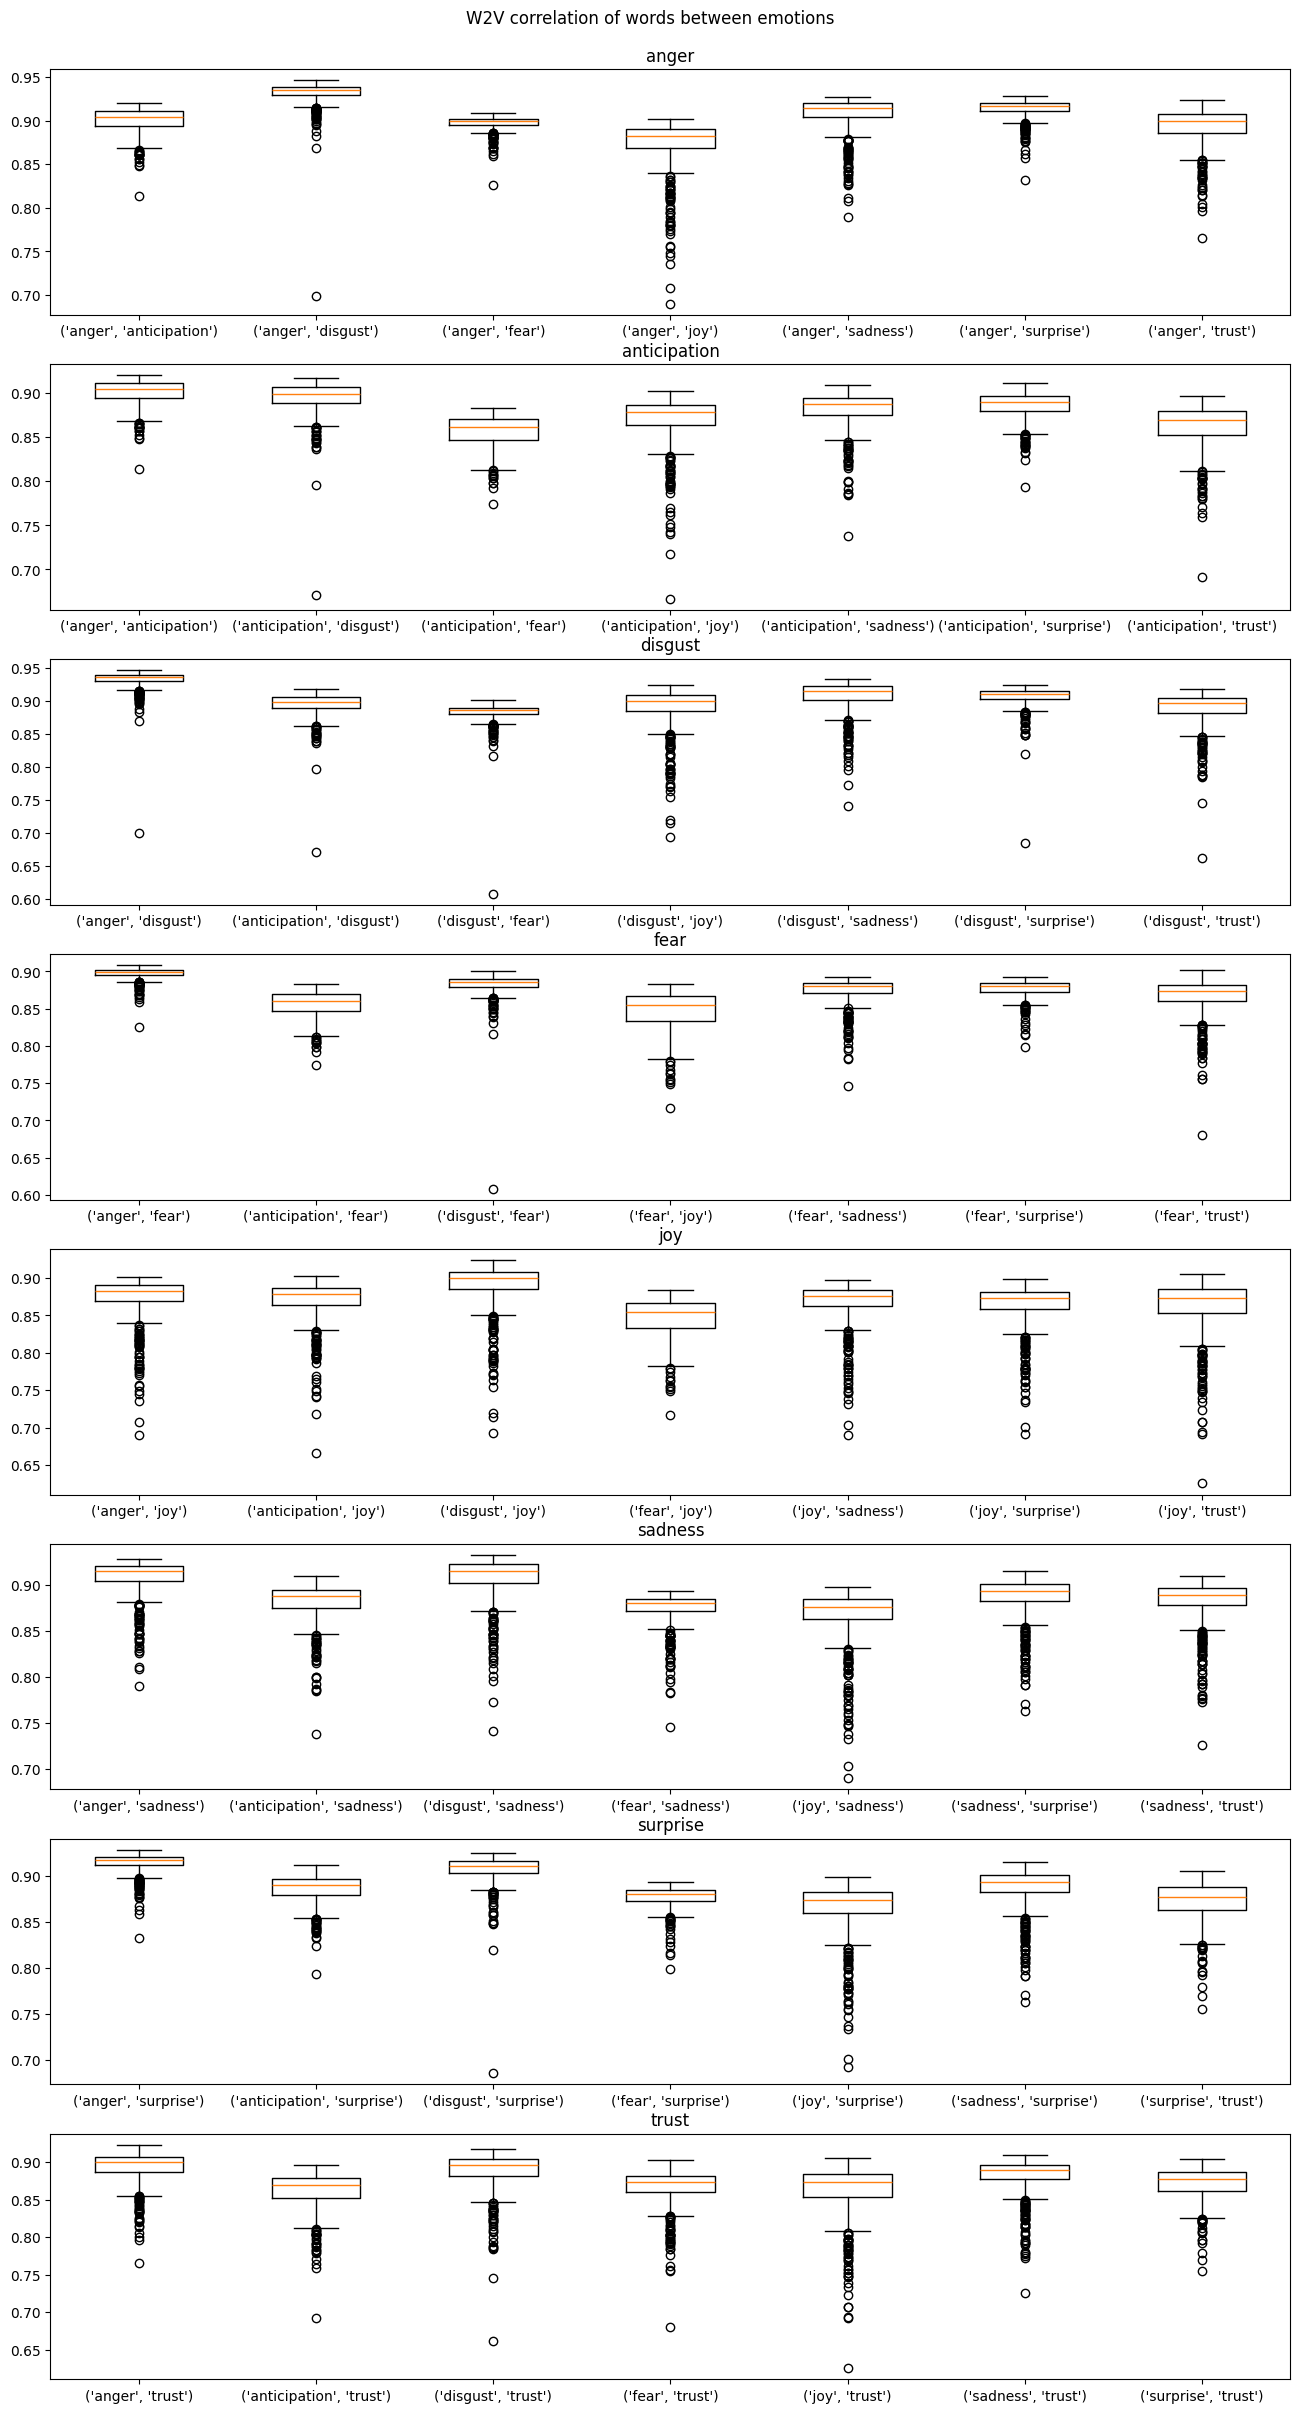

In [36]:
box_plot_word_info(words_embbed_w2v_info,"W2V correlation of words between emotions")

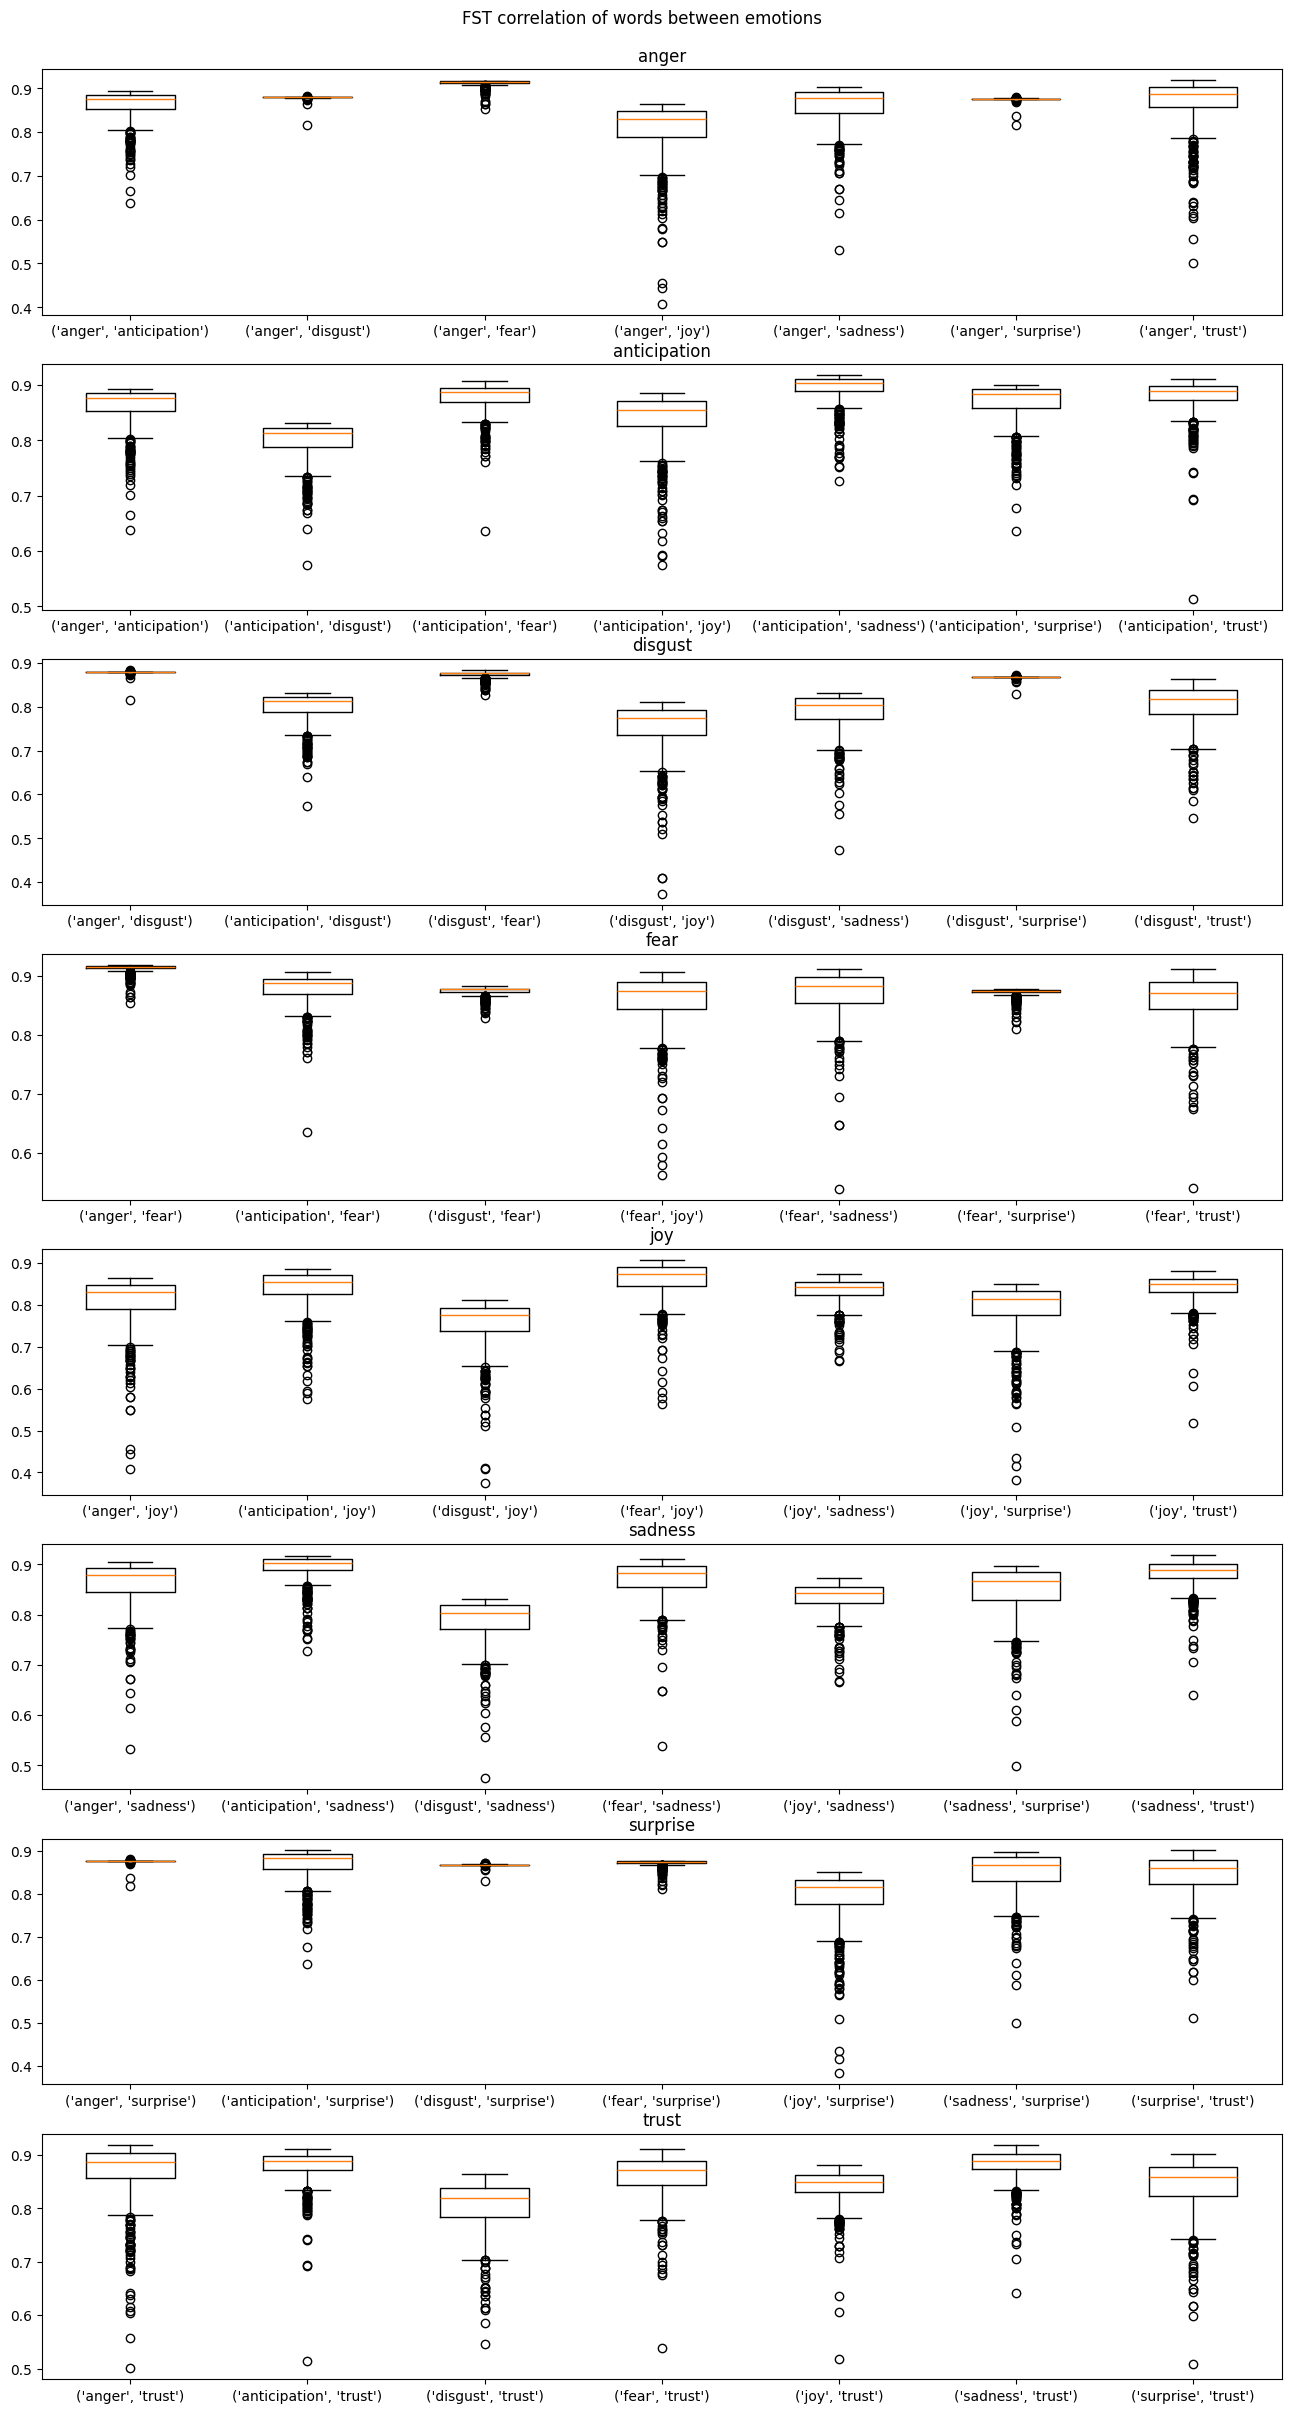

In [37]:
box_plot_word_info(words_embbed_fst_info,"FST correlation of words between emotions")

## Modulacion de embbeddings

In [ ]:
word = "bring"
emotion = "anger"
embbed_w2v = poems_w2v[emotion].wv.get_vector(word)
embbed_fst = poems_fst[emotion].wv.get_vector(word)

fm_w2v = modulate(embbed_w2v,5,100,1/len(embbed_w2v))
fm_fst = modulate(embbed_fst,5,100,1/len(embbed_fst))

In [ ]:
fig,ax = plt.subplots(3)
fig.suptitle()

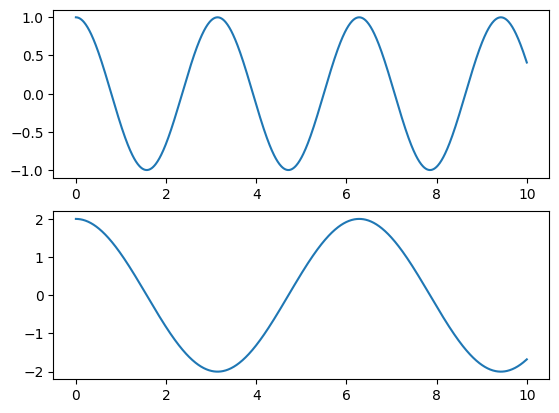

In [43]:
x = np.linspace(0,10,1000)

fig,ax = plt.subplots(2)

ax[0].plot(x,np.cos(2*x))
ax[1].plot(x,np.cos(x)+np.cos(x))